## Introduction

#### Machine Learning model to forecast the demand of the car rentals on an hourly basis.

### Import the necessary packages.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import train and test dataset

In [92]:
train=pd.read_csv("/content/gdrive/MyDrive/AV_job-a-thon-april-2022/train_E1GspfA.csv")
test=pd.read_csv("/content/gdrive/MyDrive/AV_job-a-thon-april-2022/test_6QvDdzb.csv")

#### Let's do some feature engineering on date column.

In [93]:
def pre_process(df):

  df['date_time']=pd.to_datetime((df["date"] +" "+ df['hour'].astype('str')),format="%Y-%m-%d  %H") #convert to date-time format
  df['day']=df['date_time'].dt.day #extract day from the date
  df['day_label']=df['date_time'].dt.day_name() #extract the day name from the date
  df['day_number']=df['date_time'].dt.dayofweek #extract the day number from the date
  df['month_number']=df['date_time'].dt.month #extract month number from the date
  df['month_label']=df['date_time'].dt.strftime('%b') #extract the month name from the date
  df['year_quarter']=df['date_time'].dt.quarter #extract the quarter of the year
  df['week_of_year']=df['date_time'].dt.week #extract week of the year from date
  df['year']= df['date_time'].dt.year #extract year
  df['dayofmonth'] = df['date_time'].dt.daysinmonth #extract the day of the month
  df['dayofyear'] = df['date_time'].dt.day_of_year #extract day of the year
  df['weekday']=df['date_time'].dt.day_name().isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype('int') #create weekday column
  df['weekend']=df['date_time'].dt.day_name().isin(['Saturday', 'Sunday']).astype('int') #create weekend column
  df['month_start']=df['date_time'].dt.is_month_start.astype('int') #create month start
  df['month_end']=df['date_time'].dt.is_month_end.astype('int') #create month end
  df['quarter_start']=df['date_time'].dt.is_quarter_start.astype('int') #create quarter start
  df['quarter_end']=df['date_time'].dt.is_quarter_end.astype('int') #create quarter end
  df['year_start']=df['date_time'].dt.is_year_start.astype('int') #create year start
  df['year_end']=df['date_time'].dt.is_year_end.astype('int') #create year end
  df['hour']=df['date_time'].dt.hour #create hour
 
  #function to convert month to seasons
  def month2seasons(x):
    season=""
    if x in [1, 2]:
        season = 'winter'
    elif x in [3, 4, 5]:
        season = 'summer'
    elif x in [6,7,8,9]:
        season = 'monsoon'
    elif x in [10,11,12]:
        season = 'post-monsoon'
    return season

 
  df['seasons']=df['month_number'].apply(month2seasons)

  def hours2timing(x):
    if x in range(20,23):
        timing = 'Night'
    elif x in range(5,12):
        timing = 'Morning'
    elif x in range(12, 16):
        timing = 'Afternoon'
    elif x in range(16, 20):
        timing = 'Evening'
    elif x in [23,0,1,2,3,4]:
        timing = 'Midnight'    
    else:
        timing = 'X'
    return timing



  df['timings']=df['hour'].apply(hours2timing) 

  df['rec_count']=df.groupby(['day','month_number','year'])['hour'].transform('count')



  return df

### Apply the pre-processing steps to train data.

In [94]:
train=pre_process(train)

### Apply the pre-processing steps to test data.

In [95]:
test=pre_process(test)

### Import necessary packages

In [ ]:
!pip install catboost

In [96]:
from sklearn.model_selection import  train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgbm

In [97]:
for i,col in enumerate(train.columns):
  print(f"{i}_{col}") 


0_date
1_hour
2_demand
3_date_time
4_day
5_day_label
6_day_number
7_month_number
8_month_label
9_year_quarter
10_week_of_year
11_year
12_dayofmonth
13_dayofyear
14_weekday
15_weekend
16_month_start
17_month_end
18_quarter_start
19_quarter_end
20_year_start
21_year_end
22_seasons
23_timings
24_rec_count


### Split predictor and target variables.

In [98]:
X=train.iloc[:,np.r_[1,4,6,7,9:25]]
y=train['demand']

### Label encode the categorical columns seasons and timings.

In [100]:
lbl=LabelEncoder()

In [101]:
for i in ['seasons', 'timings']:
  X[i]=lbl.fit_transform(X[[i]])

### Train and validation split

In [102]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Lgbm regressor model

In [103]:
lgbm_reg=lgbm.LGBMRegressor(n_estimator=300)
lgbm_reg.fit(X_train, y_train,early_stopping_rounds=500,
             eval_metric='rmse',
              eval_set=(X_valid, y_valid)
              )
             


[1]	valid_0's l2: 1563.36	valid_0's rmse: 39.5393
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's l2: 1478.64	valid_0's rmse: 38.4531
[3]	valid_0's l2: 1411.36	valid_0's rmse: 37.5681
[4]	valid_0's l2: 1354.24	valid_0's rmse: 36.7999
[5]	valid_0's l2: 1309.44	valid_0's rmse: 36.1861
[6]	valid_0's l2: 1268.9	valid_0's rmse: 35.6216
[7]	valid_0's l2: 1236.07	valid_0's rmse: 35.1579
[8]	valid_0's l2: 1211.13	valid_0's rmse: 34.8013
[9]	valid_0's l2: 1190.39	valid_0's rmse: 34.502
[10]	valid_0's l2: 1170.04	valid_0's rmse: 34.2059
[11]	valid_0's l2: 1154.82	valid_0's rmse: 33.9826
[12]	valid_0's l2: 1136.01	valid_0's rmse: 33.7047
[13]	valid_0's l2: 1124.49	valid_0's rmse: 33.5333
[14]	valid_0's l2: 1112.34	valid_0's rmse: 33.3517
[15]	valid_0's l2: 1102.4	valid_0's rmse: 33.2023
[16]	valid_0's l2: 1095.34	valid_0's rmse: 33.0959
[17]	valid_0's l2: 1087.87	valid_0's rmse: 32.9828
[18]	valid_0's l2: 1079.09	valid_0's rmse: 32.8494
[19]	valid_0's l2: 1071.67	vali

LGBMRegressor(n_estimator=300)

### Evaluate the model

In [104]:
pred1=lgbm_reg.predict(X_valid)
mean_squared_error(y_valid, pred1,squared=True)

984.3483505626214

### Feature Importance

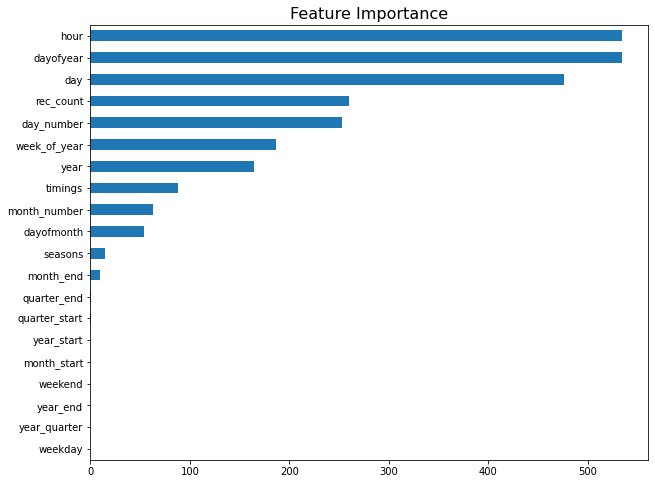

In [124]:
pd.Series(lgbm_reg.feature_importances_,X.columns).sort_values(ascending=True).plot(kind='barh',
                                                                                     figsize=(10,8));
plt.title("Feature Importance",fontsize=16);                                                                                     

### Label encode the categorical columns in test data.

In [105]:
for i in ['seasons', 'timings']:
  test[i]=lbl.fit_transform(test[[i]])

### Predict the test data

In [106]:
pred=lgbm_reg.predict(test.loc[:,X.columns])

### Create dataframe for submission

In [107]:
res=pd.DataFrame({'date':test['date'],'hour':test['hour'],'demand':pred})

### Write the data to csv

In [108]:
res.to_csv("lightgbm_regressor_final.csv",index=False)

In [117]:
train1=train

In [118]:
train1.set_index('date_time',inplace=True)

In [119]:
test1=test

In [120]:
test1.set_index('date_time',inplace=True)

In [121]:
test1['demand']=pred

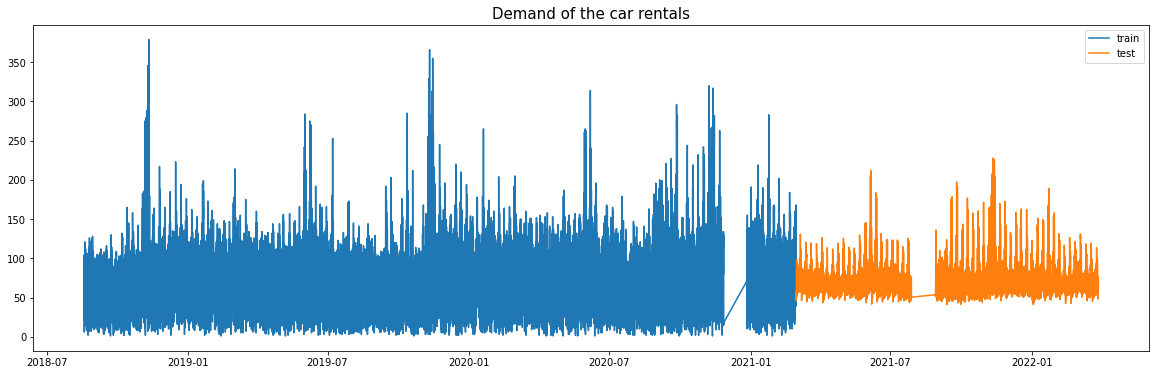

In [123]:
_=plt.figure(figsize=(20,6));
plt.plot(train1['demand'],label='train');
plt.plot(test1['demand'],label='test');
plt.legend();
plt.title('demand of the car rentals'.capitalize(),fontsize=15);